In [1]:
!pip install tqdm torch torchvision


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Libraries

import os
from time import time
from tqdm import tqdm
import numpy

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.transforms import transforms


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Data Transformer
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
# Create Dataset
TRAIN_ROOT = "is that santa/train"
TEST_ROOT = "is that santa/test"

train_ds = ImageFolder(TRAIN_ROOT, transform=tfm)
test_ds = ImageFolder(TEST_ROOT, transform=tfm)

In [7]:
# Length of Train and Test Datasets
LEN_TRAIN = len(train_ds)
LEN_TEST = len(test_ds)
print(LEN_TRAIN, LEN_TEST)

# Index Mapping
print(train_ds.class_to_idx)

614 616
{'not-a-santa': 0, 'santa': 1}


In [8]:
# Data Loader
train_loader = DataLoader(train_ds, batch_size = 30, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=30, shuffle = True)

In [9]:
# Model
model = resnet18(pretrained=True)

# Replace Output of Fully Connected Layer with Number of Labels for our Classification Problem
model.fc = Linear(in_features=512, out_features=2)
model = model.to(device)
# model = model.cuda()    # only if your system supports Nvidia CUDA

c:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:40<00:00, 1.16MB/s]


In [10]:
# Optimiser
optimiser = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

# Loss Function
loss_fn = CrossEntropyLoss()

In [11]:
for epoch in range(3):
    start = time()
    
    tr_acc = 0
    test_acc = 0
    
    # Train
    model.train()
    
    with tqdm(train_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()
            
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            
            loss = loss_fn(train_prob, ytrain)
            loss.backward()
            optimiser.step()
            
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))
            
        ep_tr_acc = tr_acc / LEN_TRAIN
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        for xtest, ytest in test_loader:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
            
        ep_test_acc = test_acc / LEN_TEST
    
    end = time()
    duration = (end - start) / 60
    print(f"Epoch: {epoch}, Time: {duration}, Loss: {loss}\nTrain_acc: {ep_tr_acc}, Test_acc: {ep_test_acc}")


100%|██████████| 21/21 [01:16<00:00,  3.63s/batch]


Epoch: 0, Time: 1.798839259147644, Loss: 0.0722629502415657
Train_acc: 0.9218241042345277, Test_acc: 0.9107142857142857


100%|██████████| 21/21 [01:12<00:00,  3.43s/batch]


Epoch: 1, Time: 1.6619022250175477, Loss: 0.2556627094745636
Train_acc: 0.9592833876221498, Test_acc: 0.9496753246753247


100%|██████████| 21/21 [01:12<00:00,  3.45s/batch]


Epoch: 2, Time: 1.6565767447153728, Loss: 0.003155624493956566
Train_acc: 0.990228013029316, Test_acc: 0.9594155844155844


In [17]:
# Image Samples
sample_1 = 'is that santa/test/santa/283.Santa.jpg'
sample_2 = 'is that santa/test/santa/474.Santa.jpg'
sample_3 = 'is that santa/test/not-a-santa/340.not-a-santa.jpg'
sample_4 = 'is that santa/test/not-a-santa/58.not-a-santa.jpg'

sample_list = [sample_1,sample_2,sample_3,sample_4]

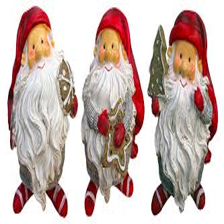

Model prediction 1, hence Santa


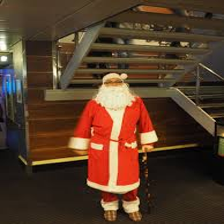

Model prediction 1, hence Santa


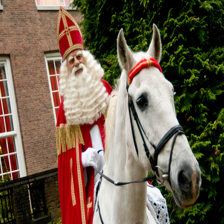

Model prediction 1, hence Santa


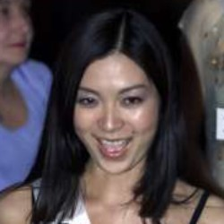

Model prediction 0, hence Not Santa


In [18]:
# Model Performance
from PIL import Image
import numpy as np

for image_path in sample_list:
    img = Image.open(image_path)
    display(img.resize((224,224)))
    img_tensor = tfm(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    if pred == 1:
        print(f"Model prediction {pred}, hence Santa")
    else:
        print(f"Model prediction {pred}, hence Not Santa")

    print("========================================================")